# STA4020 Final Project Report
### Objective:
- explore the practical applications of asset allocation methodologies in constructing and evaluating investment portfolios. 

### Aims:
- The project aims to help you apply the following key concepts:
    - mean-variance optimization (MVO)
    - equal-weighted portfolios (1/N)
    - the BlackLitterman model for incorporating views. 

</br>
The focus is on analyzing the performance of portfolios both in-sample and out-of-sample, under the given constraints.

---
### Step 1: Data Collection

This reports uses the following 5 stocks in the chosen portfolio. The original data is a 5-year dataset counting backwards from December 2024. The data contains daily open-close prices of the stock.

**Portfolio Construction:**
1) Visa Inc. (V)
2) Mastercard Inc. (MA)
3) American Express Company (AXP)
4) Palantir Technologies Inc (PLTR)
5) NIO Inc. (NIO)

In [1]:
import pandas as pd

# Define the ticker symbols
tickers = ['pltr', 'nio', 'v', 'ma', 'axp', 'tsla']

# Initialize a dictionary to store the data
stock_data = {}

# Loop through each ticker symbol and read the corresponding CSV file
for ticker in tickers:
    file_name = f"{ticker}_quotes.csv"  # Construct the file name
    stock_data[ticker] = pd.read_csv(file_name)  # Read the CSV file and store in dictionary

# Accessing individual stock data
pltr_data = stock_data['pltr']
nio_data = stock_data['nio']
v_data = stock_data['v']
ma_data = stock_data['ma']
axp_data = stock_data['axp']
tsla_data = stock_data['tsla']

**Data preprocessing steps:**
1) Check (and remove) any missing values
2) Truncate the 5 year history into a 2 year and 3 months history
    - `3 months`: Sept 2024 - Nov 2024
    - `2 years`: Aug 2022 - Aug 2024
3) Convert String values to Float (due to the `$` character)
4) Add `Returns` and `% Returns` column for the processed data
5) Partition the datasets into In-Sample and Out-Sample
    - `in_sample`: 2 years of previous data
    - `out_sample`: 3 months of latest data

**Formulae used for computing `Returns` and `% Returns`:**
1. **Daily Return (in dollars)**:
   $$\text{Daily Return} = (P_{\text{closing}} - P_{\text{opening}}) $$
   where:
   - $ P_{\text{closing}} $ = closing price
   - $ P_{\text{opening}} $ = opening price

2. **Percentage Return**:
   $$\text{Percentage Return} = \left( \frac{P_{\text{closing}} - P_{\text{opening}}}{P_{\text{opening}}} \right) \times 100$$


*note that in our dataframes, the `% Returns` columns are kept as a value between 0 & 1

At this juncture, we will also define our start and end dates for both `in` and `out` samples as variables

In [2]:
dates = {
    "in_sample" : {
        "start": '2022-08-01',
        "end": '2024-08-31',
        "start_text": 'Augest 2022',
        "end_text": 'August 2024'
    },
    "out_sample" : {
        "start" : '2024-09-01',
        "end" : '2024-11-30',
        "start_text" : 'September 2024',
        "end_text" : 'November 2024'
    }
}

Proceed with data preprocessing

In [3]:
# Check for null values in each stock data
null_checks = {
    "Palantir": pltr_data.isnull().sum().sum(),
    "NIO": nio_data.isnull().sum().sum(),
    "Visa": v_data.isnull().sum().sum(),
    "Mastercard": ma_data.isnull().sum().sum(),
    "American Express": axp_data.isnull().sum().sum(),
    "Tesla": tsla_data.isnull().sum().sum()
}

all_datasets_valid = True

for company, null_count in null_checks.items():
    if null_count > 0:
        print(f"{company} DataFrame has {null_count} null values.")
        all_datasets_valid = False

if all_datasets_valid:
    print("All datasets do not have null values.")

All datasets do not have null values.


Here we define some preprocessing functions

In [4]:
# Define function to convert the 'Date' column to datetime format
def convert_to_datetime(data):
    data['Date'] = pd.to_datetime(data['Date'])
    return data

# Define function to keep all rows within a specified date range and reindex the dataframe
def filter_by_date(data, start_date, end_date):
    data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
    data = data.reset_index(drop=True)
    return data

# Define function to remove '$' character from the selected columns and convert the remaining values to float
def clean_currency(x):
    if isinstance(x, str):
        return x.replace('$', '').replace(',', '')
    return x

# Define the columns to clean
columns_to_clean = ['Close/Last', 'Open', 'High', 'Low']

# Define function to calculate Returns and % Returns
def calculate_returns(data):
    data['Returns'] = data['Open'].astype(float) - data['Close/Last'].astype(float)
    data['% Returns'] = data['Returns'] / data['Open'].astype(float)
    return data

Then we apply these functions onto our datasets

In [5]:
# Apply the functions to each stock data and update the dictionary
for ticker in tickers:
    stock_data[ticker] = convert_to_datetime(stock_data[ticker])
    stock_data[ticker] = filter_by_date(stock_data[ticker], dates["in_sample"]["start"], dates["out_sample"]["end"])
    stock_data[ticker][columns_to_clean] = stock_data[ticker][columns_to_clean].map(clean_currency)
    stock_data[ticker] = calculate_returns(stock_data[ticker])

# Accessing individual stock data
pltr_data = stock_data['pltr']
nio_data = stock_data['nio']
v_data = stock_data['v']
ma_data = stock_data['ma']
axp_data = stock_data['axp']
tsla_data = stock_data['tsla']

Now we partition our datasets into `in_sample` and `out_sample`

In [6]:
# Create new dictionary to store each partition of the original data
stock_data_in_sample = {}
stock_data_out_sample = {}

# Loop through each ticker symbol and split the data into in-sample and out-of-sample
for ticker in tickers:
    stock_data_in_sample[ticker] = stock_data[ticker].loc[stock_data[ticker]['Date'] <= dates["in_sample"]["end"]].reset_index(drop=True)
    stock_data_out_sample[ticker] = stock_data[ticker].loc[stock_data[ticker]['Date'] > dates["in_sample"]["end"]].reset_index(drop=True)

# Accessing individual stock data
pltr_data_in_sample = stock_data_in_sample['pltr']
nio_data_in_sample = stock_data_in_sample['nio']
v_data_in_sample = stock_data_in_sample['v']
ma_data_in_sample = stock_data_in_sample['ma']
axp_data_in_sample = stock_data_in_sample['axp']
tsla_data_in_sample = stock_data_in_sample['tsla']

pltr_data_out_sample = stock_data_out_sample['pltr']
nio_data_out_sample = stock_data_out_sample['nio']
v_data_out_sample = stock_data_out_sample['v']
ma_data_out_sample = stock_data_out_sample['ma']
axp_data_out_sample = stock_data_out_sample['axp']
tsla_data_out_sample = stock_data_out_sample['tsla']


---
### Step 2: MVE Portfolio Construction
In this section, we construct the mean-variance efficient (MVE) portfolio using the `in_sample` data

##### 2.1 Use `in_sample` data to calculate the average returns (%) and covariance matrix of the selected assets in our portfolio

In [7]:
import numpy as np 

# put all in-sample % return data into the same dataframe
returns_pct_in_sample = pd.DataFrame({
    'PLTR': pltr_data_in_sample['% Returns'],
    'NIO': nio_data_in_sample['% Returns'],
    'V': v_data_in_sample['% Returns'],
    'MA': ma_data_in_sample['% Returns'],
    'AXP': axp_data_in_sample['% Returns'],
    'TSLA': tsla_data_in_sample['% Returns']
})

# Calculate expected returns and covariance matrix
expected_returns = returns_pct_in_sample.mean()
cov_matrix = returns_pct_in_sample.cov()

# Create a DataFrame to display the expected returns and covariance matrix
output_table = pd.DataFrame(cov_matrix)
output_table.loc['Expected Returns'] = expected_returns

# Reorder the rows to have 'Expected Returns' at the top
output_table = output_table.reindex(['Expected Returns'] + list(cov_matrix.index))

output_table

,PLTR,NIO,V,MA,AXP,TSLA
Expected Returns,-0.001605,0.001812,-0.000646,-0.000572,-0.000853,-0.000060
PLTR,0.001057,0.000526,0.000088,0.000111,0.000147,0.000442
NIO,0.000526,0.001356,0.000095,0.000110,0.000150,0.000477
V,0.000088,0.000095,0.000104,0.000088,0.000071,0.000085
MA,0.000111,0.000110,0.000088,0.000108,0.000076,0.000085
AXP,0.000147,0.000150,0.000071,0.000076,0.000179,0.000144
TSLA,0.000442,0.000477,0.000085,0.000085,0.000144,0.000821


#### 2.2 Optimize portfolio weights 
The objective of this optimization problem is to maximize the Sharpe Ratio under the 'no-short-selling' constraint i.e.  $  \omega_i \geq 0$. This is equivalent to minimizing the negative Sharpe Ratio: 

**• Negative Sharpe Ratio:**

$$Sharpe Ratio = - \frac{w_{mve}^T \mu^e}{\sqrt{w_{mve}^T \Sigma w_{mve}}}$$

where:

* $\mu^e$ is the expected returns
* $\Sigma$ is the covariance matrix
* $w_{mve}$ is the optimal weights

In [8]:
from scipy.optimize import minimize

n_assets = len(tickers)

mu = expected_returns
Sigma = cov_matrix

# Define minimizing function
def portfolio_obj(weights, mu, Sigma):
    portfolio_return = np.dot(weights, mu)
    portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    return -portfolio_return / portfolio_variance

# Set constraints
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, None) for asset in range(n_assets))

# Set initial weights (equal distribution, 1/n)
initial_weights = np.ones(n_assets) / n_assets

# Optimize
mve_optimal_solution = minimize(portfolio_obj, initial_weights, args=(mu, Sigma),
                            method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
mve_optimal_weights = mve_optimal_solution.x

print("Optimal Weights:", mve_optimal_weights)

Optimal Weights: [0.00000000e+00 1.00000000e+00 2.78722775e-18 2.87312703e-17
 1.20046401e-17 0.00000000e+00]


#### 2.3 MVE portfolio VS Equal weighted portfolio
We assess the performance of each portfolio

In [11]:
# Performance metrics for MVE portfolio
mve_return = np.dot(returns_pct_in_sample, mve_optimal_weights)
mve_exp_return = np.mean(mve_return)
mve_std_dev = np.std(mve_return)
mve_sharpe_ratio = mve_return.mean() / mve_std_dev  # Risk-free rate is 0

# Performance metrics for Equal-Weighted Portfolio
equal_weights = np.ones(n_assets) / n_assets
equal_return = np.dot(returns_pct_in_sample, equal_weights)
equal_exp_return = np.mean(equal_return)
equal_std_dev = np.std(equal_return)
equal_sharpe_ratio = equal_return.mean() / equal_std_dev

# Display the comparisons using a dataframe
mve_eqw_performance_metrics = pd.DataFrame({
    'MVE Portfolio': [mve_exp_return, mve_std_dev, mve_sharpe_ratio],
    'Equal-Weighted Portfolio': [equal_exp_return, equal_std_dev, equal_sharpe_ratio]
}, index=['Expected Return', 'Standard Deviation', 'Sharpe Ratio'])

mve_eqw_performance_metrics

,MVE Portfolio,Equal-Weighted Portfolio
Expected Return,0.001812,-0.000321
Standard Deviation,0.036791,0.015811
Sharpe Ratio,0.049248,-0.020282


We observed that the expected returns of MVE is higher than that of the Equal-weighted portfolio. This means that the optimized weights successfully achieve higher returns on the `in-sample` data. The MVE portfolio also experiences higher volatility (standard deviation) which can be explained as it takes more risks during the optimization process to minimize the objective function.  

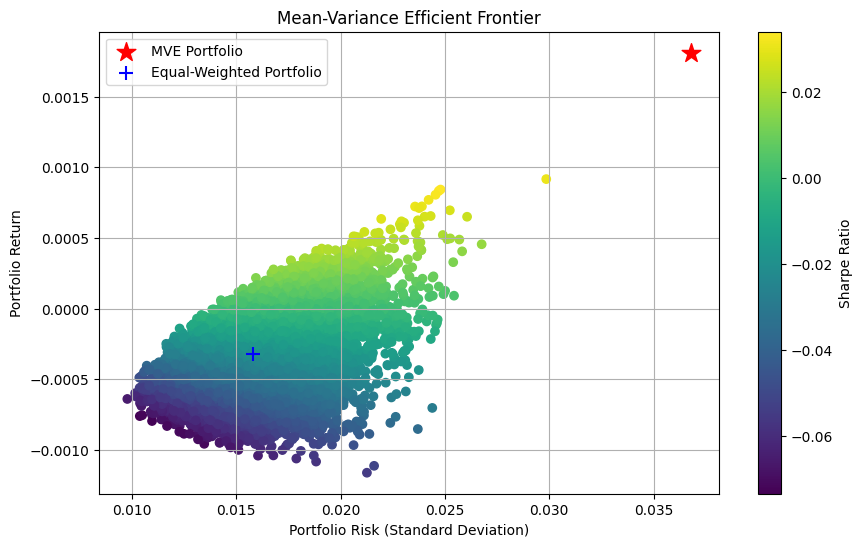

In [13]:
import matplotlib.pyplot as plt

# Generate portfolios
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # Normalize weights
    weights_record.append(weights)

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = portfolio_std_dev
    results[1, i] = portfolio_return
    results[2, i] = (portfolio_return - 0) / portfolio_std_dev  # Sharpe Ratio

# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results.T, columns=['std_dev', 'returns', 'sharpe_ratio'])

# Plotting the MVE Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results_df['std_dev'], results_df['returns'], c=results_df['sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(mve_std_dev, mve_exp_return, color='red', marker='*', s=200, label='MVE Portfolio')
plt.scatter(equal_std_dev, equal_exp_return, color='blue', marker='+', s=100, label='Equal-Weighted Portfolio')
plt.title('Mean-Variance Efficient Frontier')
plt.xlabel('Portfolio Risk (Standard Deviation)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.grid()
plt.show()


We can see from the above Mean-Variance Efficient Frontier, the MVE portfolio is more optimal than the Equal-weighted portfolio. This tells us that our MVE portfolio represents the best risk-return trade off. The MVE portfolio in theory offers a higher level of expected return for the given risk the portfolio exhibits. Being close to the frontier also suggests that our portfolio has effectively achieved a higher level of diversification without compromising expected returns.

---
### Step 3: Black Litterman Model
In this section we implement the Black-Litterman (BL) Model, this will incorporate some qualitative research of our portfolio assets.

#### 3.1 Compute the prior expected excess returns
- Use long-window average, can be achieved using mean of returns of assets
- Assign value of $ \tau $ = `0.025` for covariance matrix calculation
- Assign value of $ \delta $ = `2.5` for Risk Aversion Coefficient

In [23]:
# Calculate the prior expected excess returns
def calculate_prior(assets):
    return returns_pct_in_sample.mean()

# Covariance matrix calculation
def calculate_covariance(assets):
    return returns_pct_in_sample.cov()

# Parameters
tau = 0.025
d = 2.5  # Risk aversion coefficient
market_weights = np.array([1/len(tickers)] * len(tickers))  # Equal weights

#### 3.2 Define Views 
The views (relative or absolute) are based on news articles and analyst reports that are readily available on the internet.

* **View 1:** Neutral view; Visa is expected to have a daily excess return of 0% with an uncertainty of 2%.  
**Explanation:** *(Dey, 2024)*
    - Visa's stock has climbed 20% in 2024, but this is below the industry average of 21.6% and significantly less than American Express's 61.3% gain. This indicates that while Visa is performing steadily, it is not keeping pace with its peers.
    - Visa maintains a dominant share in the U.S. payments market, controlling 47% of credit card balances. This strong position suggests a stable revenue stream, but it also faces challenges from rising competition and regulatory pressures.
    - Visa's forward P/E ratio of 27.22X is above its five-year median and the industry average, indicating that the stock may be overvalued at current levels. This could limit upside potential in the near term.
    - Ongoing legal issues and potential regulatory changes, such as the Credit Card Competition Act, could impact Visa's growth trajectory and introduce volatility, contributing to the uncertainty in expected returns.
    - Despite short-term challenges, Visa's strong fundamentals and ongoing shift towards cashless payments support a stable long-term growth outlook. However, the immediate environment suggests a cautious approach.
    

* **View 2:** Relative view; Nio is expected to outperform Tesla by 0.8% daily with an uncertainty of 3%.  
**Explanation:** *(NARAYANAN & Daily, 2024)*
    - Nio's stock has shown strong momentum, rising 5.4% recently and recovering from near four-year lows. This positive trend is bolstered by record EV deliveries and the introduction of the Onvo L60, which is expected to drive future sales.
    - Nio's focus on affordable EVs and the integration of advanced technology, such as Nvidia's AI chips, positions it favorably against Tesla in the competitive Chinese market. The recent stimulus measures from the Chinese government also support the broader EV sector, benefiting Nio.
    - Nio's year-over-year sales growth of 11.6% and its strong monthly performance indicate robust demand. In contrast, Tesla, while still a leader, faces increasing competition and pricing pressures in China.
    - The uncertainty of 3% reflects market volatility and potential fluctuations in consumer demand, regulatory changes, and competition dynamics. Both companies are subject to external economic factors, but Nio's recent performance and strategic initiatives provide a more optimistic outlook. 

* **View 3:** Palantir's expected daily excess return is 4%, with an uncertainty of 2%.  
**Explanation:** *(PIMENTEL & Daily, 2024)*
    - Palantir has positioned itself as a leader in data analytics and AI solutions, catering to both government and commercial sectors. The increasing reliance on data-driven decision-making across industries enhances its growth prospects.
    - The company has secured significant contracts, particularly with government agencies and large enterprises, which bolsters its revenue stream and showcases its value proposition. This trend is likely to continue as more organizations seek advanced data solutions.
    - Investor sentiment around tech stocks, especially those involved in AI and data analytics, remains positive. This optimism can lead to increased demand for Palantir's shares, contributing to the expected excess return.
    - Despite some volatility, Palantir's innovative offerings and strategic partnerships support a favorable outlook. The stock may experience fluctuations based on market conditions, but the overall trend appears upward.
    - The uncertainty reflects potential market volatility, competition in the tech space, and the company's ability to maintain growth momentum amidst changing economic conditions. 

* **View 4:** American Express is forecasted to outperform Visa by 1% daily with an uncertainty of 3%.  
**Explanation:** *(Saibil, 2024)*
    - American Express operates on a "closed loop" model, acting as both a card issuer and a payment network. This allows it to maintain higher profit margins compared to Visa, which primarily acts as a network, relying on banks for credit. As a result, American Express can generate significant revenue from fees and interest.
    - American Express targets an affluent customer base, which tends to spend more and is less sensitive to economic downturns. This positions the company well for sustained revenue growth, especially in uncertain economic conditions.
    - American Express has shown strong performance over the past few years, benefiting from a younger customer demographic and resilience during economic volatility. In contrast, Visa's growth has been steady but slower, particularly in comparison to American Express's recent gains.
    - With a robust business model and diversified revenue streams, American Express has demonstrated consistent earnings growth and profitability, which enhances investor confidence.
    - While Visa has a larger market share, its lower profit margins and reliance on transaction volume may limit its immediate growth potential compared to American Express.

* **View 5:** Mastercard daily expected excess returns is 3% with an uncertainty of 2%.  
**Explanation:** *(DETAR & Daily, 2024)*
    - Mastercard has consistently posted double-digit sales and profit growth over the last six quarters, with a recent earnings per share (EPS) growth of 15% and revenue growth of 13%. This solid performance underpins a positive outlook for the stock.
    - The stock has risen approximately 49% over the past 14 months, reflecting strong investor confidence. The recent increase in its Relative Strength (RS) Rating to 71 indicates that it is outperforming the majority of stocks, enhancing its attractiveness to investors.
    - Analysts forecast continued growth, with expectations of 17% earnings growth and 13% higher sales in the upcoming quarter. This positive outlook supports the expectation of excess returns.
    - As a leading player in the payment processing industry, Mastercard benefits from its dominant market position and increasing consumer reliance on digital payments, especially during peak shopping seasons.
    - The uncertainty reflects potential market volatility and competition within the finance sector. However, Mastercard's strong fundamentals and market leadership mitigate some of these risks.


Now we convert our qualitative views to quantitative players to fit into the BL model:

In [24]:
# Define views based on our research (placeholder values)
# ticket order: pltr, nio, v, ma, axp, tsla

# P: Links views to assets (K x N)
P = np.array([[0, 0, 1, 0, 0, 0],  # View 1
              [0, 1, 0, 0, 0, -1], # View 2
              [1, 0, 0, 0, 0, 0], # View 3
              [0, 0, -1, 0, 1, 0],  # View 4
              [0, 0, 0, 1, 0, 0]])  # View 5

# Q: Expected excess returns for views (K x 1)
q = np.array([0.0,
              0.008,
              0.04,
              0.01,
              0.03])

# Omega: Covariance matrix of uncertainties (K x K)
Omega = np.diag([0.0004, 0.0009, 0.0004, 0.0009, 0.0004])  # Uncertainty of the views

# output P, q, Omega
print("P:\n", P, "\n")
print("q:", q, "\n")
# Print Omega without scientific notation
np.set_printoptions(suppress=True)
print("Omega:\n", Omega, "\n")

P:
 [[ 0  0  1  0  0  0]
 [ 0  1  0  0  0 -1]
 [ 1  0  0  0  0  0]
 [ 0  0 -1  0  1  0]
 [ 0  0  0  1  0  0]] 

q: [0.    0.008 0.04  0.01  0.03 ] 

Omega:
 [[0.0004 0.     0.     0.     0.    ]
 [0.     0.0009 0.     0.     0.    ]
 [0.     0.     0.0004 0.     0.    ]
 [0.     0.     0.     0.0009 0.    ]
 [0.     0.     0.     0.     0.0004]] 



**Know the Players:**

- $K \times N$ matrix **P:** Links views to assets (weights for each view).
- $K \times K$ matrix **Ω (Omega):** Covariance matrix of view uncertainties.
- $K \times K$ matrix **Ω⁻¹:** Precision of views (inverse covariance).
- $K \times 1$ vector **q:** Expected excess returns of views.

where $K$ is the number of Views and $N$ is the number of Assets

#### 3.3 Formulate BL model

**Prior Mean:**

$$\pi = d \Sigma w_m$$

where:

* $d$ is the average risk aversion
* $\Sigma$ is the covariance matrix
* $w_m$ is the market weights

**Posterior Mean:**

$$\mu_e = (\tau \Sigma^{-1} + P^T \Omega^{-1} P)^{-1} (\tau \Sigma^{-1} \pi + P^T \Omega^{-1} q)$$

where:

* $P$ is the matrix of views
* $q$ is the vector of expected returns based on your views
* $\Omega$ is the uncertainty of the views (often set as a diagonal matrix)

**Posterior Covariance:**

$$\Sigma_{BL} = \Sigma + (\tau \Sigma^{-1} + P^T \Omega^{-1} P)^{-1}$$

note:

**• $(\tau \Sigma)^{-1}$:**

- Represents the precision (inverse covariance) of the prior.
- Smaller τ implies higher confidence in the prior.

**• $(\tau \Sigma)^{-1}\pi$:**

- Precision-adjusted prior for μₑ.
- Balances the prior information with its uncertainty.

**• $(\tau \Sigma)^{-1}\pi$ controls how strongly the prior (market equilibrium) influences the posterior mean of μₑ.**

In [25]:
# Define Black-Litterman Model
def black_litterman(assets):
    prior_returns = calculate_prior(assets)
    covariance_matrix = calculate_covariance(assets)

    # Calculate prior mean
    pi = d * covariance_matrix @ market_weights

    # Calculate posterior mean
    term1 = np.linalg.inv(tau * covariance_matrix) + P.T @ np.linalg.inv(Omega) @ P
    term2 = np.linalg.inv(term1)
    mu_e = term2 @ (np.linalg.inv(tau * covariance_matrix) @ pi + P.T @ np.linalg.inv(Omega) @ q)

    # Calculate posterior covariance
    Sigma_BL = np.linalg.inv(term1)

    return mu_e, Sigma_BL

#### 3.4 Portfolio Optimization
We compute and optimize the portfolio weights using the posterior expected returns, making sure to impose the no-short-selling constraint.

In [26]:
# Define BL optimization function
def optimize_portfolio(mu_e, Sigma_BL):
    num_assets = len(mu_e)

    # Objective function: minimize negative sharpe ratio
    def bl_portfolio_obj(weights):
        portfolio_return = np.dot(weights, mu_e)
        portfolio_variance = np.sqrt(np.dot(weights.T, np.dot(Sigma_BL, weights)))
        return -portfolio_return / portfolio_variance

    # Constraints and bounds
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Sum of weights = 1
    bounds = [(0, None) for _ in range(num_assets)]  # No short selling

    # Initial guess (equal distribution)
    initial_weights = np.ones(num_assets) / num_assets

    # Minimize the variance
    result = minimize(bl_portfolio_obj, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

In [27]:
# Execute Black-Litterman model
posterior_returns, posterior_covariance = black_litterman(tickers)
posterior_optimal_weights = optimize_portfolio(posterior_returns, posterior_covariance)

post_portfolio_return = np.dot(posterior_optimal_weights, posterior_returns)
post_portfolio_sd = np.sqrt(np.dot(posterior_optimal_weights.T, np.dot(posterior_covariance, posterior_optimal_weights)))
post_sharpe_ratio = post_portfolio_return / post_portfolio_sd

# Display results
print(f"""
Posterior Portfolio Results:
Expected Return: {post_portfolio_return:.4f}
Standard Deviation: {post_portfolio_sd:.4f}
Sharpe Ratio: {post_sharpe_ratio:.4f}
Optimal Weights: {posterior_optimal_weights}
""")


Posterior Portfolio Results:
Expected Return: 0.0022
Standard Deviation: 0.0028
Sharpe Ratio: 0.7725
Optimal Weights: [0.42448649 0.09295441 0.01922307 0.3338634  0.1010441  0.02842853]



---
### Step 4: Out-of-sample Portfolio Evaluation
In this section we will evaluate the performance of each portfolio (MVE, 1/N, and Black-Litterman) on the `out_sample` data

In [28]:
# put all out-sample % return data into the same dataframe
returns_pct_out_sample = pd.DataFrame({
    'PLTR': pltr_data_out_sample['% Returns'],
    'NIO': nio_data_out_sample['% Returns'],
    'V': v_data_out_sample['% Returns'],
    'MA': ma_data_out_sample['% Returns'],
    'AXP': axp_data_out_sample['% Returns'],
    'TSLA': tsla_data_out_sample['% Returns']
})

In [29]:
# Define function to calculate the out-of-sample portfolio performance
def calculate_portfolio_performance(returns, weights):
    portfolio_return = np.dot(returns, weights)
    exp_port_return = np.mean(portfolio_return)
    std_dev = np.std(portfolio_return)
    sharpe_ratio = exp_port_return / std_dev
    return exp_port_return, std_dev, sharpe_ratio

# Calculate the out-of-sample (oos) portfolio performance
mve_oos_exp_return, mve_oos_sd, mve_oos_sr = calculate_portfolio_performance(returns_pct_out_sample, mve_optimal_weights)
equal_oos_exp_return, equal_oos_sd, equal_oos_sr = calculate_portfolio_performance(returns_pct_out_sample, equal_weights)
bl_oos_exp_return, bl_oos_sd, bl_oos_sr = calculate_portfolio_performance(returns_pct_out_sample, posterior_optimal_weights)

# Display the out-of-sample performance metrics in a dataframe
oos_performance_metrics = pd.DataFrame({
    'MVE Portfolio': [mve_oos_exp_return, mve_oos_sd, mve_oos_sr],
    'Equal-Weighted Portfolio': [equal_oos_exp_return, equal_oos_sd, equal_oos_sr],
    'BL Portfolio': [bl_oos_exp_return, bl_oos_sd, bl_oos_sr]
}, index=['Expected Return', 'Standard Deviation', 'Sharpe Ratio'])

oos_performance_metrics


,MVE Portfolio,Equal-Weighted Portfolio,BL Portfolio
Expected Return,-0.000608,-0.001839,-0.003688
Standard Deviation,0.042801,0.012643,0.014228
Sharpe Ratio,-0.014200,-0.145484,-0.259236


**Analysis of OOS Performance Results**

Sharpe Ratio Comparison:
- The MVE Portfolio has the least negative Sharpe ratio at `-0.014200`, indicating it has the relatively better risk-adjusted performance compared to the other two portfolios.
- The BL Portfolio has the most negative Sharpe ratio at `-0.259236`, suggesting it has significantly underperformed on a risk-adjusted basis.
- The Equal-Weighted Portfolio has a Sharpe ratio of `-0.145484`, which is better than the BL Portfolio but worse than the MVE Portfolio.

Expected Returns and Standard Deviation:
- The MVE Portfolio has the lowest expected return at `-0.000608`, while the Equal-Weighted Portfolio has a slightly higher expected return of `-0.001839`.
- The BL Portfolio has the lowest expected return at `-0.003688`.
- In terms of standard deviation, the BL Portfolio has the highest at `0.014228`, followed by the Equal-Weighted Portfolio at `0.012643`, and the MVE Portfolio at `0.042801`.

Overall Comparison:
- Based on the Sharpe ratio, the MVE Portfolio appears to be the best performer among the three, despite all having negative Sharpe ratios.
- The BL Portfolio exhibits the worst risk-adjusted performance, with the most negative Sharpe ratio and the lowest expected return.
- The Equal-Weighted Portfolio falls in the middle, with a Sharpe ratio and expected return better than the BL Portfolio but worse than the MVE Portfolio.

What does Negative Sharpe Ratio Indicate?:
- The portfolios are underperforming, investors might be better off from a risk-free investment.
- The selection of assets in the portfolios have resulted in inefficient investment, they are not effectively using the capital invested. This leads to bad performance. 
- The portfolios exhibit very high levels of risks, and such high volatility is not being compensated by higher returns.

Review of Strategies used:
1. MVE portfolio
* Advantages:
    - By minizing portfolio variance or (in our case) negative Sharpe Ratio i.e. Maxmize Sharpe Ratio, this option can lead to more stable returns.
* Limitation:
    - Lower expected returns due to prioritization of risk reduction over higher returns.
    - Highly sensitive input parameters (sample mean and covariance matrix), which are inaccurate estimates for forecasting the future.
    - Not suitable for growth-oriented investors.

2. Equal-Weighted portfolio
* Advantages:
    - Simple implementation.
    - Great diversification.
* Limitations:
    - Ill-suited for risk-adjusted returns, this can lead to underperformance during times of high market volatility.

3. Black-Litterman portfolio
* Advantages:
    - Robust to estimation errors with the help of external insight and investor views of the market.
    - Incorporating domain knowledge helps with optimal asset allocation, especially in dynamic markets.
* Limitations:
    - Used of complex modeling methods, difficult to implement.
    - Subjective towards investor's viewpoints since views rely on the accuracy of the investor's and their due diligence. This can lead to bianess.


Final Insights:
The Equal-Weighted Portfolio's intermediate performance (between MVE and BL) highlights the potential trade-offs between simplicity, diversification, and risk-adjusted returns.


We can further explore and analyse more about the volatility of the assets in the portfolios

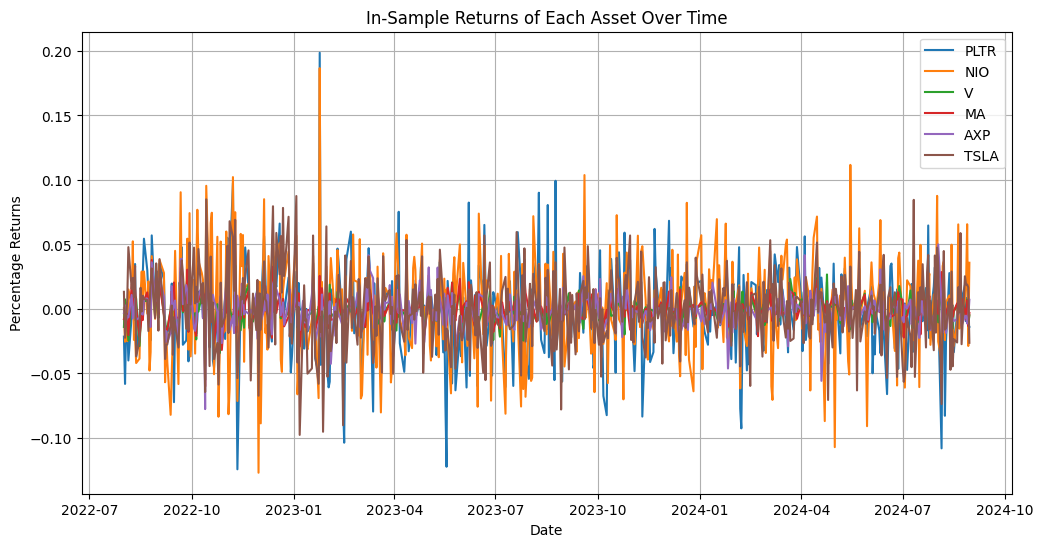

In [ ]:
import matplotlib.pyplot as plt

# Plotting the returns of each asset over time
plt.figure(figsize=(12,6))

for ticker in tickers:
    plt.plot(stock_data_in_sample[ticker]['Date'], stock_data_in_sample[ticker]['% Returns'], label=ticker.upper())

plt.title('In-Sample Returns of Each Asset Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage Returns')
plt.legend()
plt.grid(True)
plt.show()

We can observe that our portfolio exhibits a general trend of very high volatility. This would indicate to risk-averse investors to further diversify or balance out their portfolios to mitigate risk. 

A new set of assets can be further retested using the procedures outlined in this report to explore and benchmark their volatility, robustness and applicability to real world industries.

---
### References:

1. DETAR, J., & Daily, I. B. (2024, December 12). “Steady Eddie” Stock Mastercard Hits An All-Time High, Gets Rating Upgrade. Investor’s Business Daily. https://www.investors.com/news/stocks-generating-improved-relative-strength-mastercard-2/

2. Dey, K. P. (2024, December 11). Should You Buy Visa Stock Before 2024 Ends? Read This Before You Swipe. Yahoo Finance. https://finance.yahoo.com/news/buy-visa-stock-2024-ends-200000020.html

3. Glover, G. (2024, December 11). Palantir Stock Slides Ahead of Potentially Joining the Nasdaq 100. Barrons; Barrons. https://www.barrons.com/articles/palantir-stock-nasdaq-ai-27108d1d

4. NARAYANAN, A., & Daily, I. B. (2024, October). Tesla Archrival Tops 1 Million EV Milestone, Breaks Out. Investor’s Business Daily. https://www.investors.com/news/nio-stock-soaring-tesla-rival-model-y-nvidia-ai-chip-brain/

5. PIMENTEL, B., & Daily, I. B. (2024, December 12). Palantir Stock Is Hot, But Don’t Chase It Now, Says Analyst. Investor’s Business Daily. https://www.investors.com/news/technology/palantir-stock-pltr-caution-baird-analyst/

6. Saibil, J. (2024, December 13). Better Warren Buffett Stock: Visa vs. American Express. The Motley Fool. https://www.fool.com/investing/2024/12/13/better-buffett-stock-visa-vs-american-express/